In [10]:
def Inspecting_Data(df):
#1️⃣ Viewing First & Last Rows
   print("First 5 rows:\n", df.head())
   print("\nLast 5 rows:\n", df.tail())

# 2️⃣ General Dataset Information
   print("\nDataset Info:")
   df.info()

# 3️⃣ Summary Statistics
   print("\nSummary Statistics:\n", df.describe())

# 4️⃣ Checking Data Types
   print("\nData Types:\n", df.dtypes)

# 5️⃣ Shape & Column Names
   print("\nShape of DataFrame:", df.shape)
   print("\nColumn Names:", df.columns)

# 6️⃣ Checking Missing Values
   print("\nMissing Values:\n", df.isnull().sum())

# 7️⃣ Checking Duplicate Rows
   print("\nDuplicate Rows Count:", df.duplicated().sum())
   print("\nDuplicate Rows:\n", df[df.duplicated()])




In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler


def clean_dataset(df, target_column=None, scale_numerical=True, drop_threshold=0.5):
    """
    Cleans a raw DataFrame by handling:
    - Missing values
    - Duplicates
    - Incorrect dtypes
    - Irrelevant columns
    - Scaling
    - Encoding categorical variables
    - Outliers (IQR-based removal for extreme cases)

    Parameters:
        df (pd.DataFrame): input dataset
        target_column (str): column name of the target (optional)
        scale_numerical (bool): whether to scale numeric features
        drop_threshold (float): threshold of missing % to drop column

    Returns:
        Cleaned DataFrame (X), Target (y)
    """
# copy bana lo Original Dataframe ki jisse orginal Dataframe me Baad me chalke kuch change na ho,best Practoce rehti hai ye 
    df = df.copy()
# Check Karo ki shape kaisi hai Dataframe ki kitni rows and cols hain 
    print(f"Initial shape: {df.shape}")

    # Drop columns with too many missing values
    missing_percent = df.isnull().mean()
    cols_to_drop = missing_percent[missing_percent > drop_threshold].index
    df.drop(columns=cols_to_drop, inplace=True)
    print(
        f"Dropped columns with >{int(drop_threshold * 100)}% missing: {list(cols_to_drop)}"
    )

    # Drop duplicates
    df.drop_duplicates(inplace=True)

    # Handle missing values (basic strategy)
    for col in df.columns:
        if df[col].dtype in ["float64", "int64"]:
            df[col].fillna(df[col].median(), inplace=True)
        else:
            df[col].fillna(df[col].mode()[0], inplace=True)

    # Drop constant columns
    constant_cols = [col for col in df.columns if df[col].nunique() <= 1]
    df.drop(columns=constant_cols, inplace=True)

    # Remove ID-like columns (optional logic)
    id_cols = [
        col
        for col in df.columns
        if "id" in col.lower() and df[col].nunique() == df.shape[0]
    ]
    df.drop(columns=id_cols, inplace=True)

    # Outlier removal (IQR method, optional)
    numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]

    # Encoding categorical features
    cat_cols = df.select_dtypes(include=["object", "category"]).columns
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

    # Scale numeric features
    if scale_numerical:
        scaler = StandardScaler()
        numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
        if target_column and target_column in numeric_cols:
            numeric_cols.remove(target_column)
        df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

    # Split target and features
    if target_column:
        y = df[target_column]
        X = df.drop(columns=[target_column])
        return X, y
    else:
        return df


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

#By deafault Target Column is Setted to None , agar Target col me kuch aega wo set ho jaega , 
# fif size bhi define pehle hi kardi hai jisse har baar fig kitne size me banegi na batana padhe plt.figure(fig size=(x,y))
def visualize_dataset(df, target_column=None, max_cat=10, figsize=(16, 5)):
    """
    Visualize basic insights of a dataset:
    - Missing values heatmap
    - Histograms of numerical features
    - Count plots of categorical features (low-cardinality)
    - Correlation heatmap
    - Target distribution
    - Target vs top categorical/numerical features (if provided)

    Parameters:
        df (pd.DataFrame): the input dataset
        target_column (str): name of the target column
        max_cat (int): max unique values to consider a feature as categorical
        figsize (tuple): base figure size for plots
    """
    df = df.copy()

    print(f"Dataset shape: {df.shape}")
    print("First 5 rows:")
    display(df.head())

    # Missing value heatmap
    plt.figure(figsize=(12, 5))
    sns.heatmap(df.isnull(), cbar=False, cmap="Reds")
    plt.title("Missing Value Heatmap")
    plt.show()

    # Numerical columns
    num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
    if target_column and target_column in num_cols:
        num_cols.remove(target_column)

    # Categorical columns
    cat_cols = [
        col
        for col in df.select_dtypes(include=["object", "category"]).columns
        if df[col].nunique() <= max_cat
    ]

    # Histograms for numerical features

    for col in num_cols:
        data = df[col].dropna()
        if data.nunique() <= 1:
            continue  # Skip constant columns

        mean_val = data.mean()
        median_val = data.median()

        plt.figure(figsize=(10, 4))
        sns.histplot(data, bins="auto", kde=True, color="skyblue", edgecolor="black")

        # Mean and Median lines
        plt.axvline(
            mean_val, color="red", linestyle="--", label=f"Mean: {mean_val:.2f}"
        )
        plt.axvline(
            median_val, color="green", linestyle="-", label=f"Median: {median_val:.2f}"
        )

        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.legend()
        plt.tight_layout()
        plt.show()

    # Count plots for categorical features
    for col in cat_cols:
        plt.figure(figsize=figsize)
        sns.countplot(data=df, x=col, order=df[col].value_counts().index)
        plt.title(f"Count Plot - {col}")
        plt.xticks(rotation=45)
        plt.show()

    # Correlation heatmap
    plt.figure(figsize=(12, 8))
    corr = df.select_dtypes(include=["number"]).corr()
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", square=True)
    plt.title("Correlation Heatmap")
    plt.show()

    # Target column analysis
    if target_column:
        print(f"\nTarget column: {target_column}")
        print(df[target_column].value_counts(normalize=True))

        # Target distribution
        plt.figure(figsize=(6, 4))
        sns.countplot(data=df, x=target_column)
        plt.title(f"Target Distribution: {target_column}")
        plt.show()

        # Target vs categorical
        for col in cat_cols:
            plt.figure(figsize=figsize)
            sns.barplot(data=df, x=col, y=target_column, ci=None)
            plt.title(f"{target_column} vs {col}")
            plt.xticks(rotation=45)
            plt.show()

        # Target vs numerical
        for col in num_cols[:5]:  # limit to top 5 for quick view
            plt.figure(figsize=figsize)
            sns.boxplot(data=df, x=target_column, y=col)
            plt.title(f"{col} by {target_column}")
            plt.show()


Mini Guide
1.Import the dataset and explore basic info (nulls, data types).
2.Handle missing values using mean/median/imputation.
3.Convert categorical features into numerical using encoding.
4.Normalize/standardize the numerical features.
5.Visualize outliers using boxplots and remove them


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [14]:
# importing Titanic Dataset
df = sns.load_dataset("titanic")
Inspecting_Data(df)

First 5 rows:
    survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
0         0       3    male  22.0      1      0   7.2500        S  Third   
1         1       1  female  38.0      1      0  71.2833        C  First   
2         1       3  female  26.0      0      0   7.9250        S  Third   
3         1       1  female  35.0      1      0  53.1000        S  First   
4         0       3    male  35.0      0      0   8.0500        S  Third   

     who  adult_male deck  embark_town alive  alone  
0    man        True  NaN  Southampton    no  False  
1  woman       False    C    Cherbourg   yes  False  
2  woman       False  NaN  Southampton   yes   True  
3  woman       False    C  Southampton   yes  False  
4    man        True  NaN  Southampton    no   True  

Last 5 rows:
      survived  pclass     sex   age  sibsp  parch   fare embarked   class  \
886         0       2    male  27.0      0      0  13.00        S  Second   
887         1       1  female  19.0

In [15]:
num_features = df.select_dtypes(include=['int64','float64']).columns.tolist()
cat_features = df.select_dtypes(include=['object','category']).columns.tolist()
print("Numerical features: ")
print(num_features)
print("Categorical Features: ")
print(cat_features)

Numerical features: 
['survived', 'pclass', 'age', 'sibsp', 'parch', 'fare']
Categorical Features: 
['sex', 'embarked', 'class', 'who', 'deck', 'embark_town', 'alive']


Dataset shape: (891, 15)
First 5 rows:


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


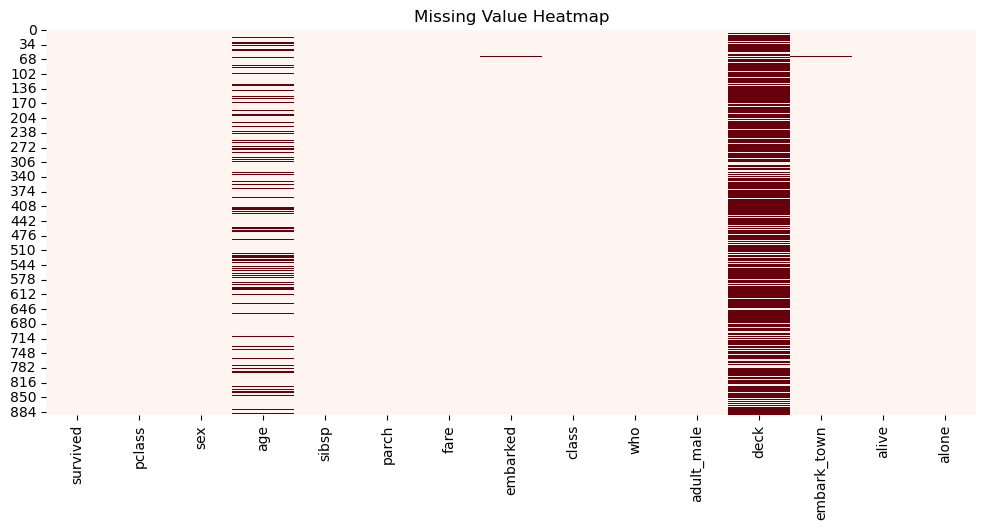

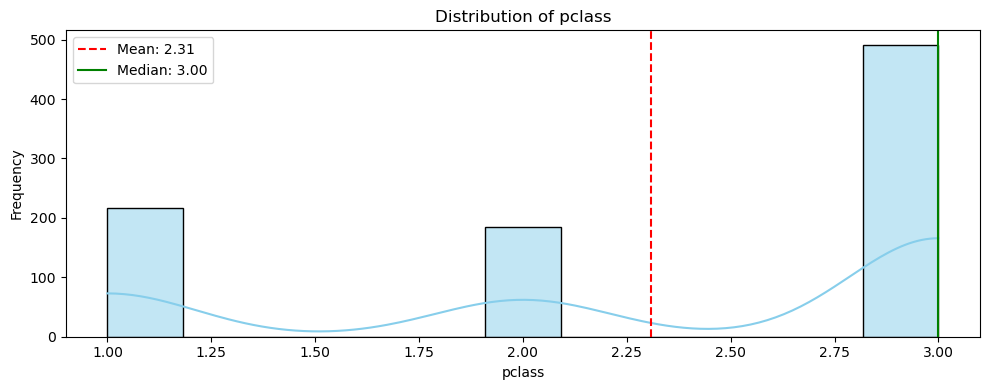

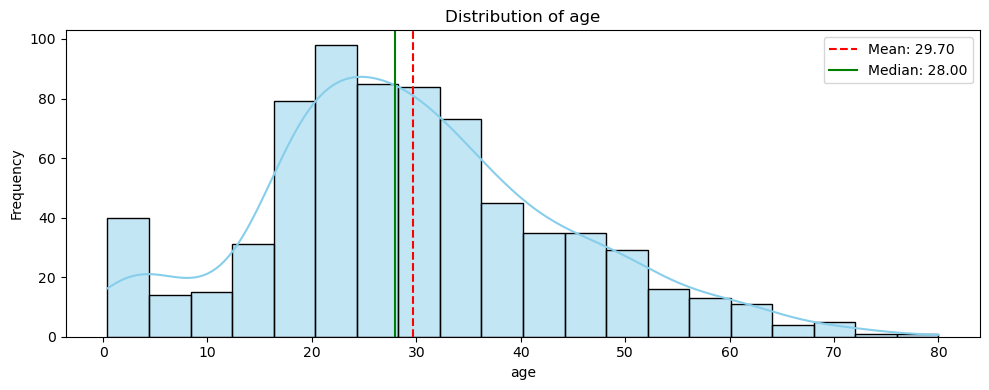

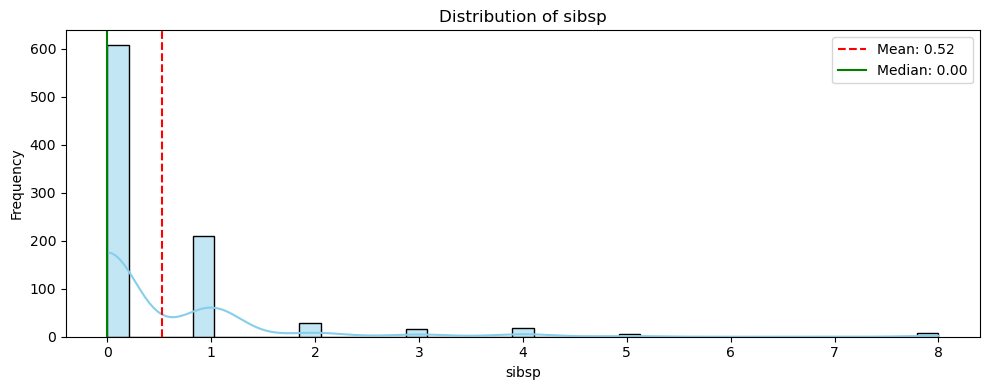

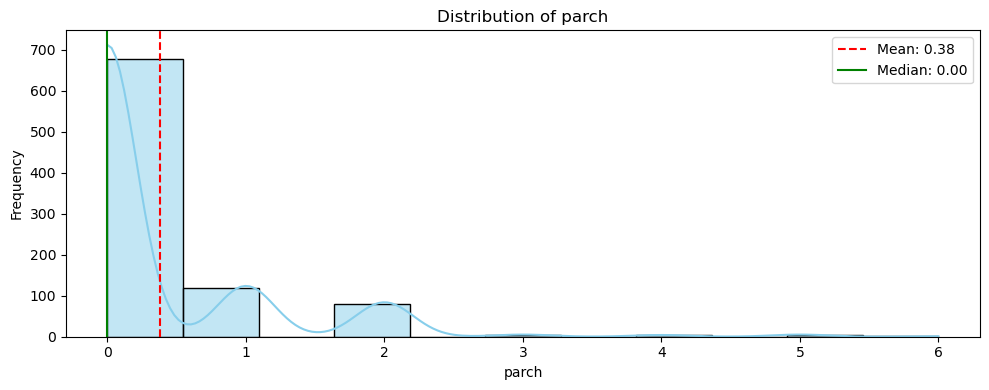

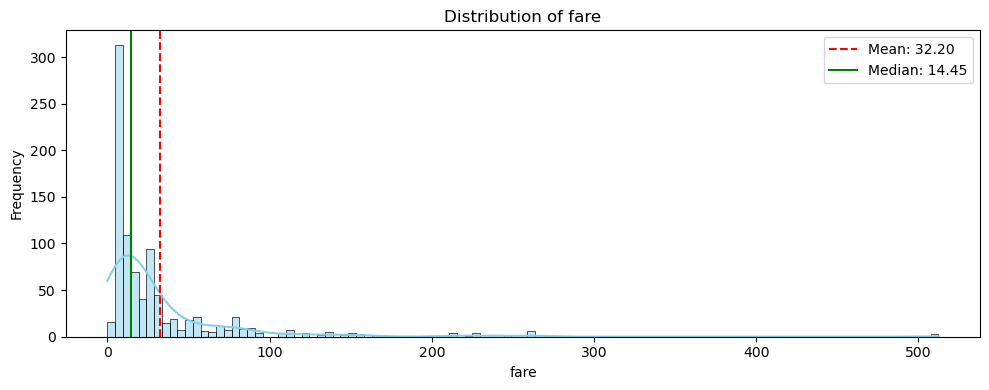

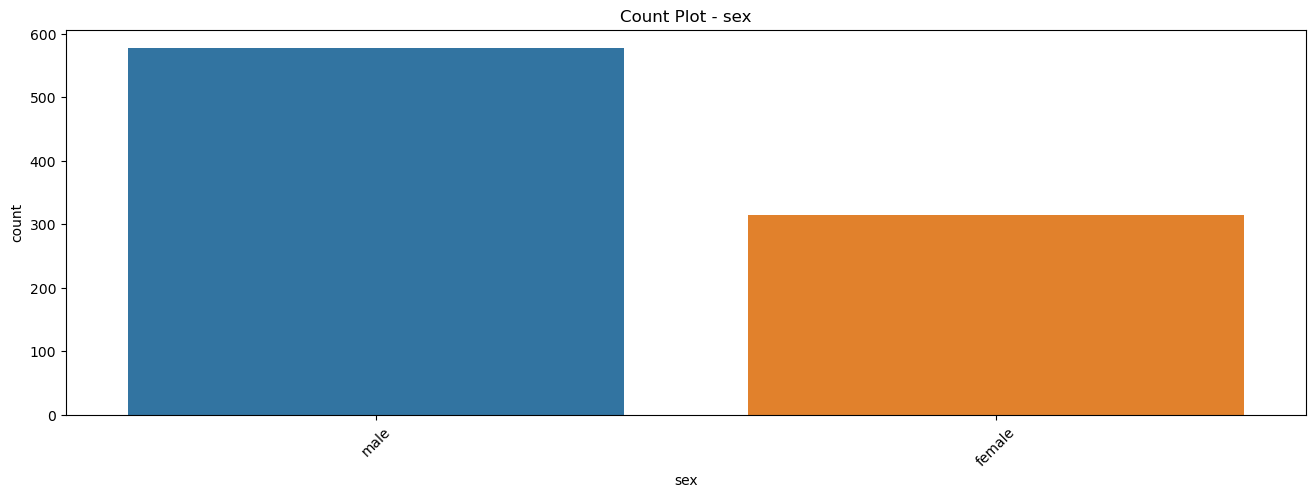

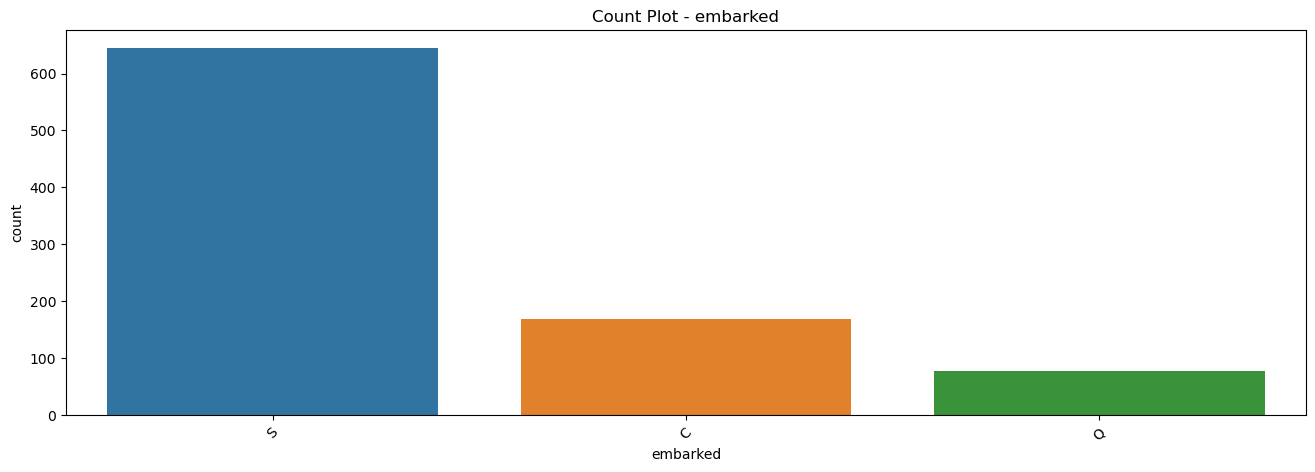

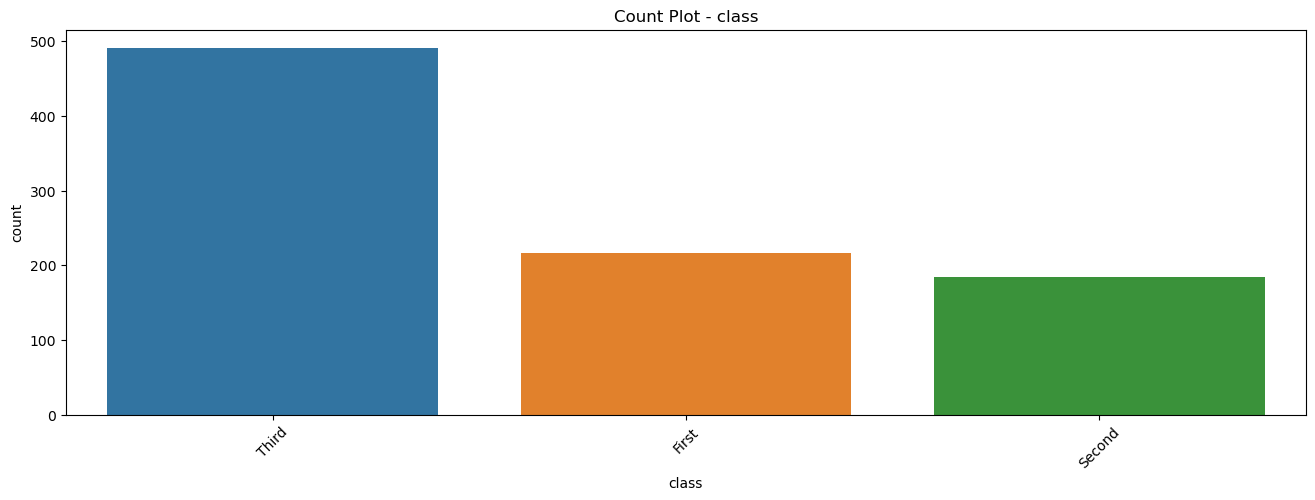

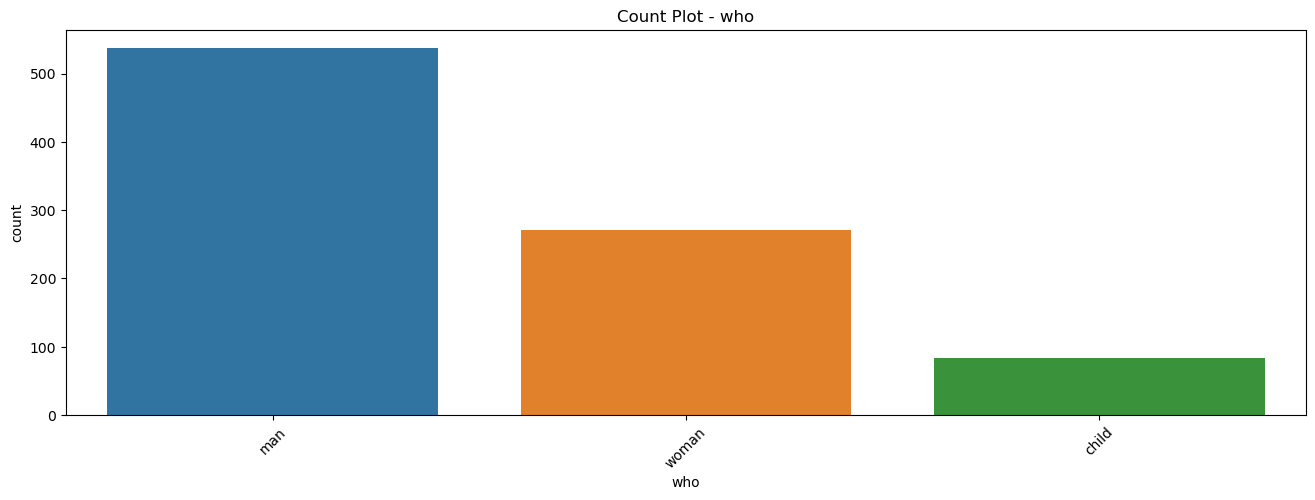

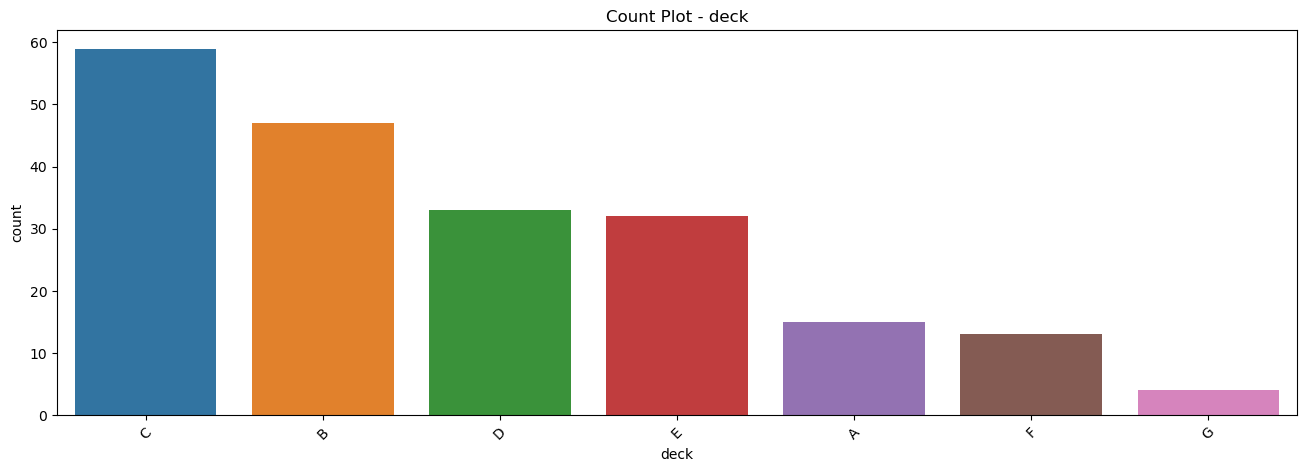

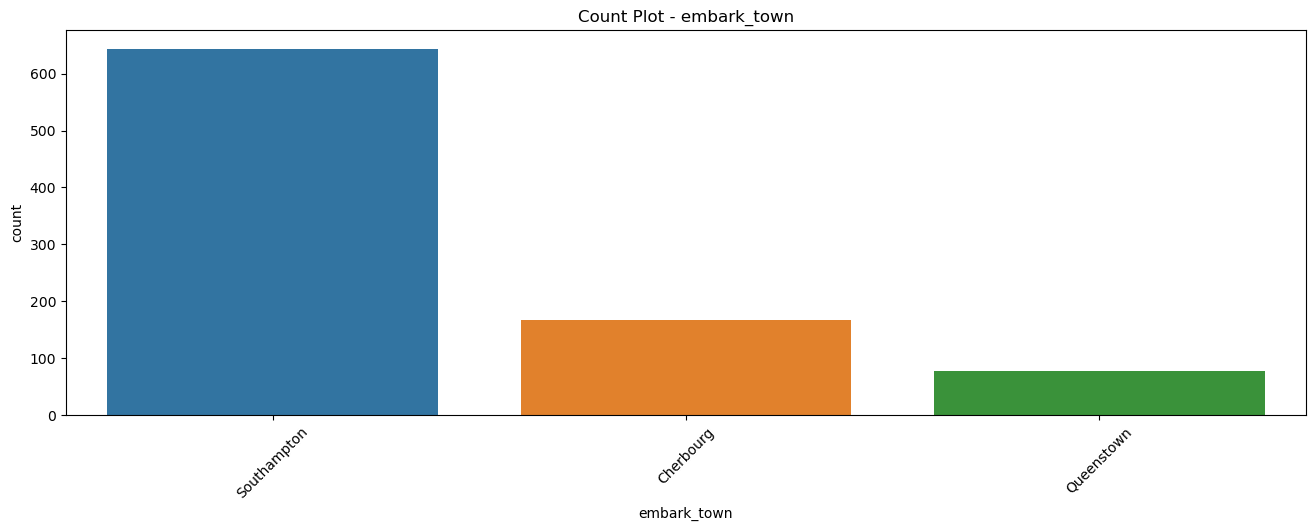

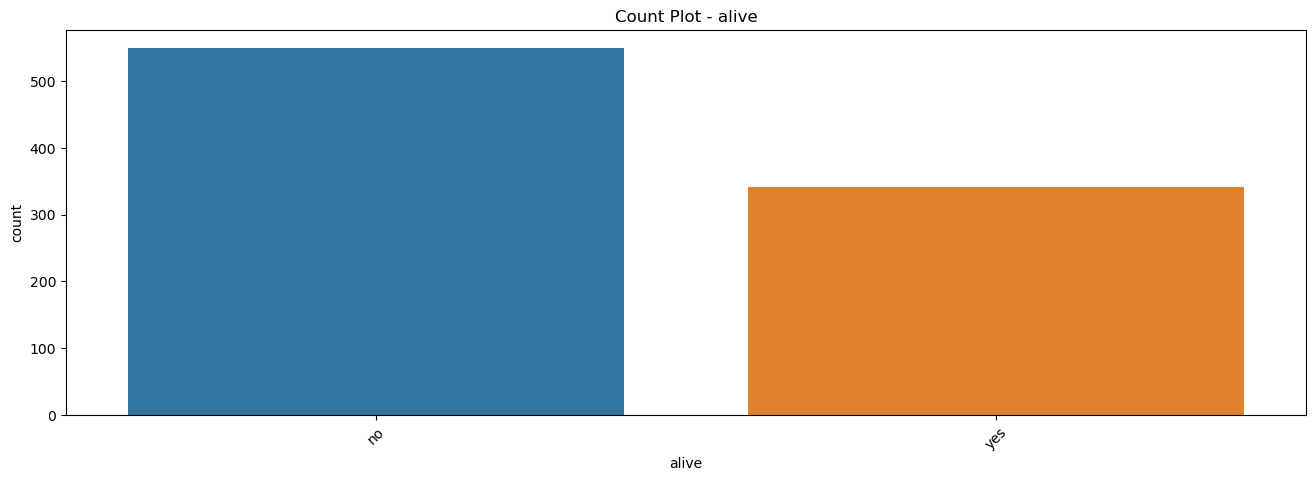

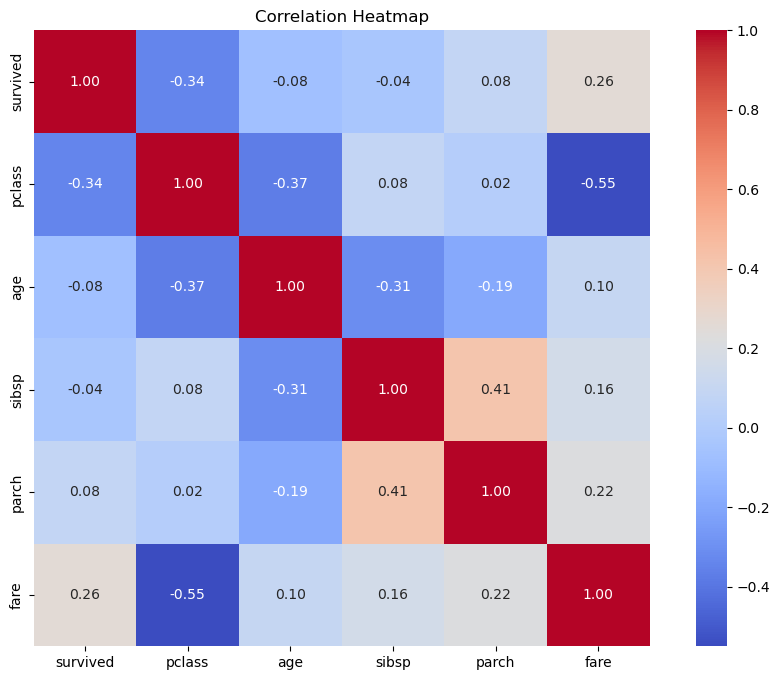


Target column: survived
survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64


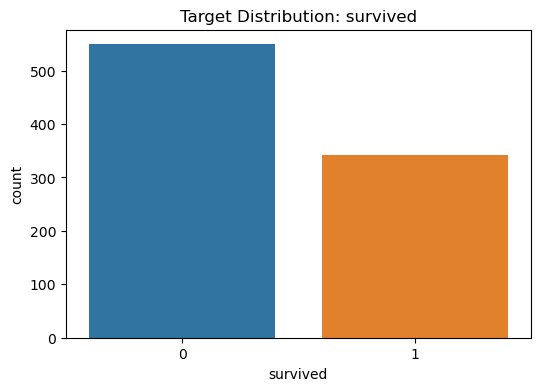

C:\Users\mohda\AppData\Local\Temp\ipykernel_24836\3538760263.py:103: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x=col, y=target_column, ci=None)


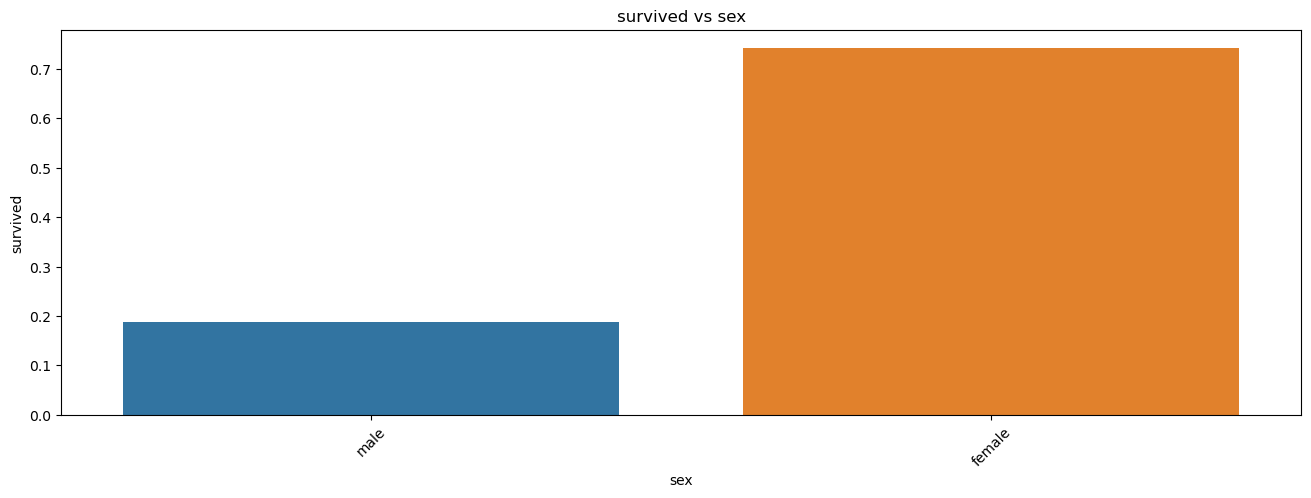

C:\Users\mohda\AppData\Local\Temp\ipykernel_24836\3538760263.py:103: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x=col, y=target_column, ci=None)


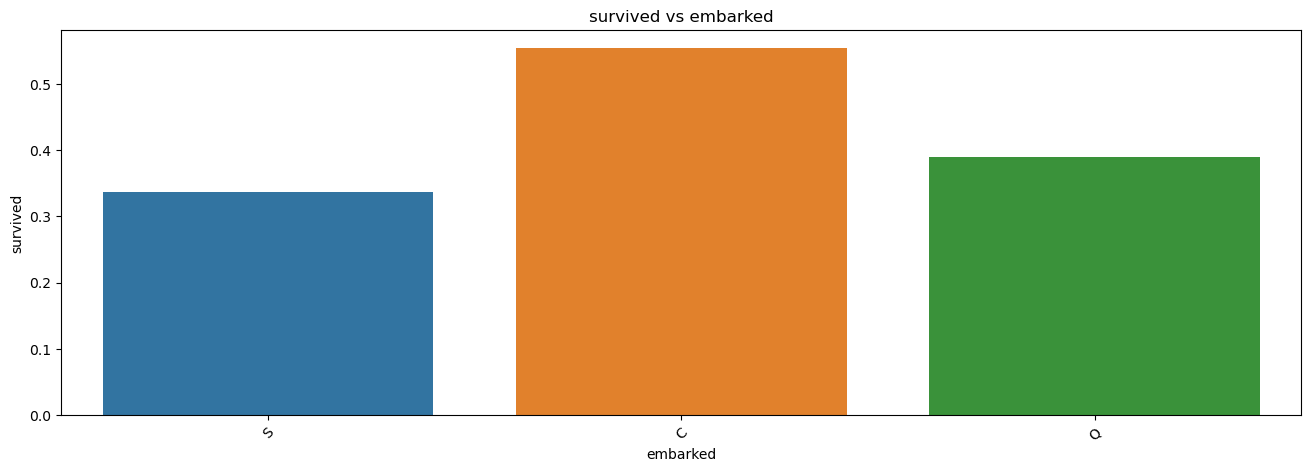

C:\Users\mohda\AppData\Local\Temp\ipykernel_24836\3538760263.py:103: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x=col, y=target_column, ci=None)


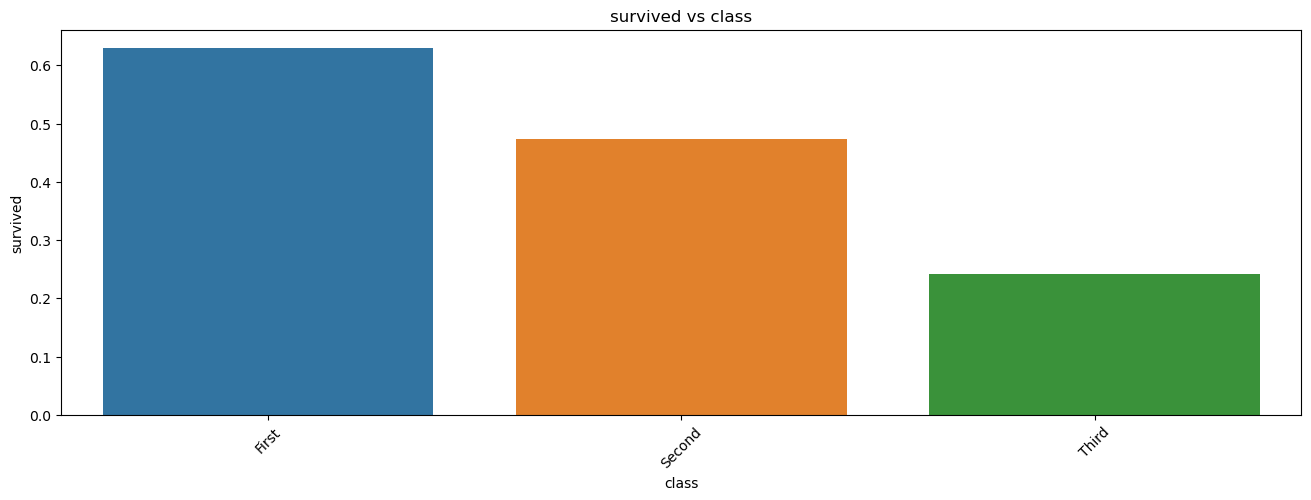

C:\Users\mohda\AppData\Local\Temp\ipykernel_24836\3538760263.py:103: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x=col, y=target_column, ci=None)


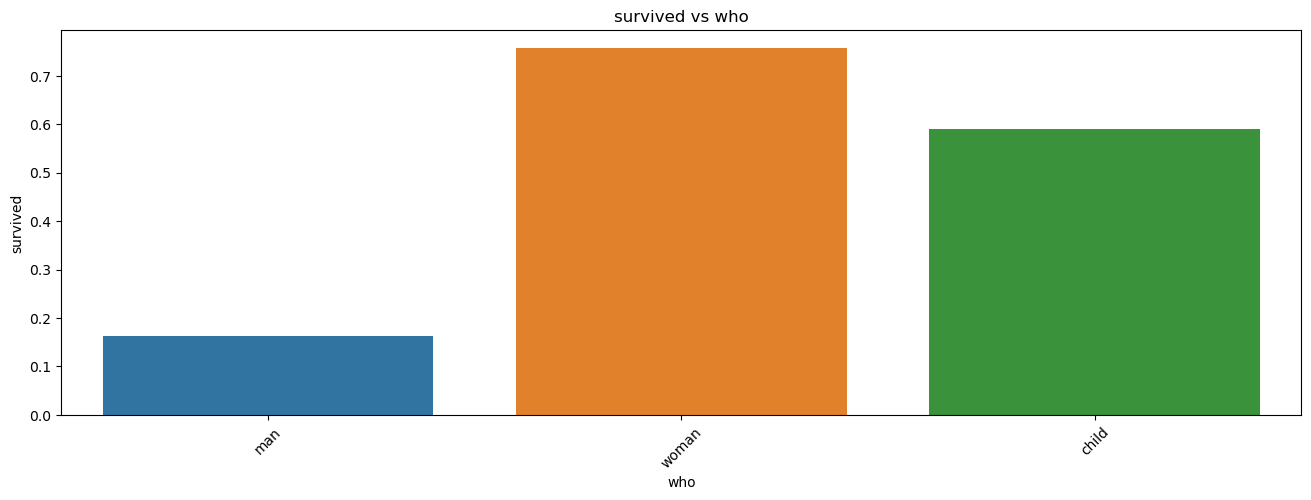

C:\Users\mohda\AppData\Local\Temp\ipykernel_24836\3538760263.py:103: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x=col, y=target_column, ci=None)


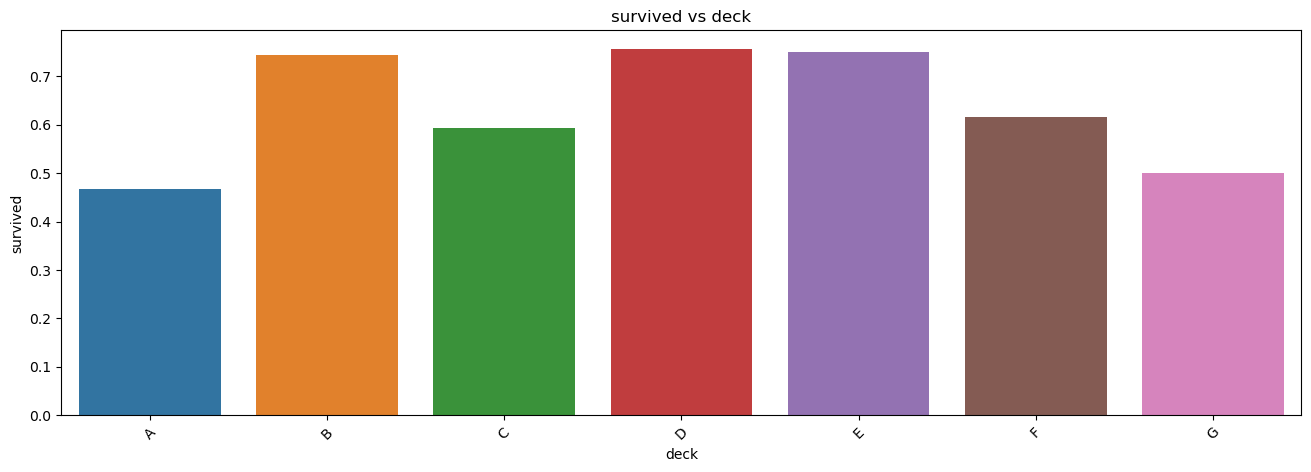

C:\Users\mohda\AppData\Local\Temp\ipykernel_24836\3538760263.py:103: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x=col, y=target_column, ci=None)


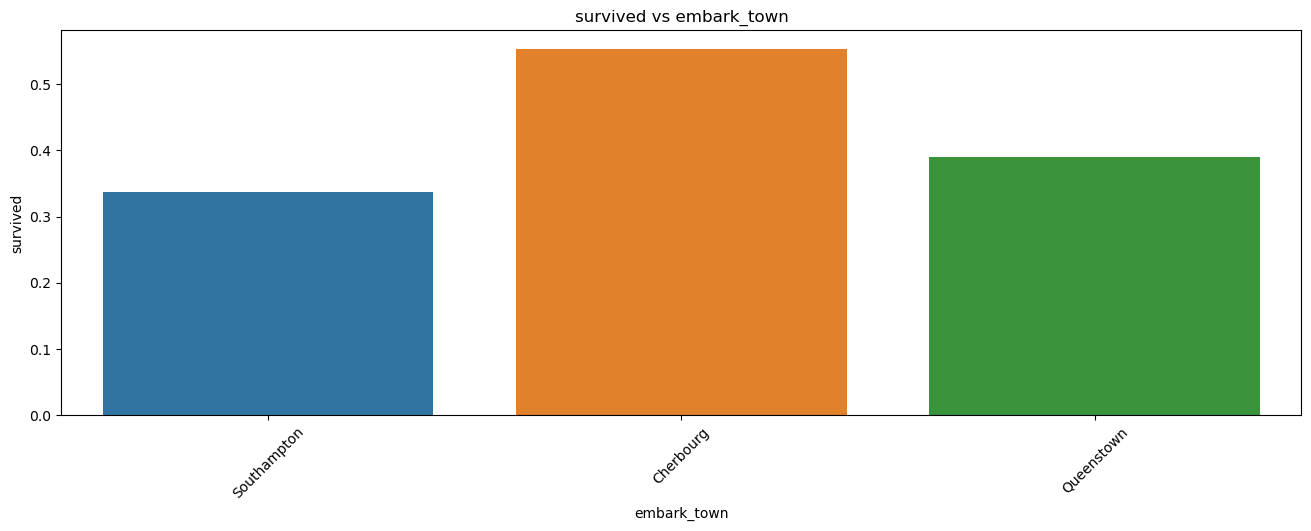

C:\Users\mohda\AppData\Local\Temp\ipykernel_24836\3538760263.py:103: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x=col, y=target_column, ci=None)


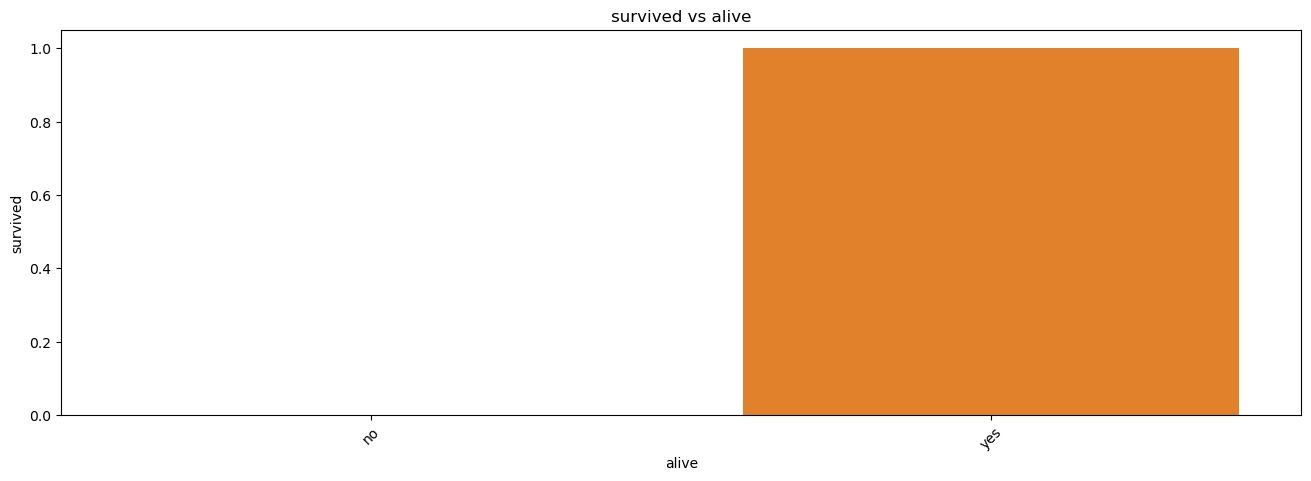

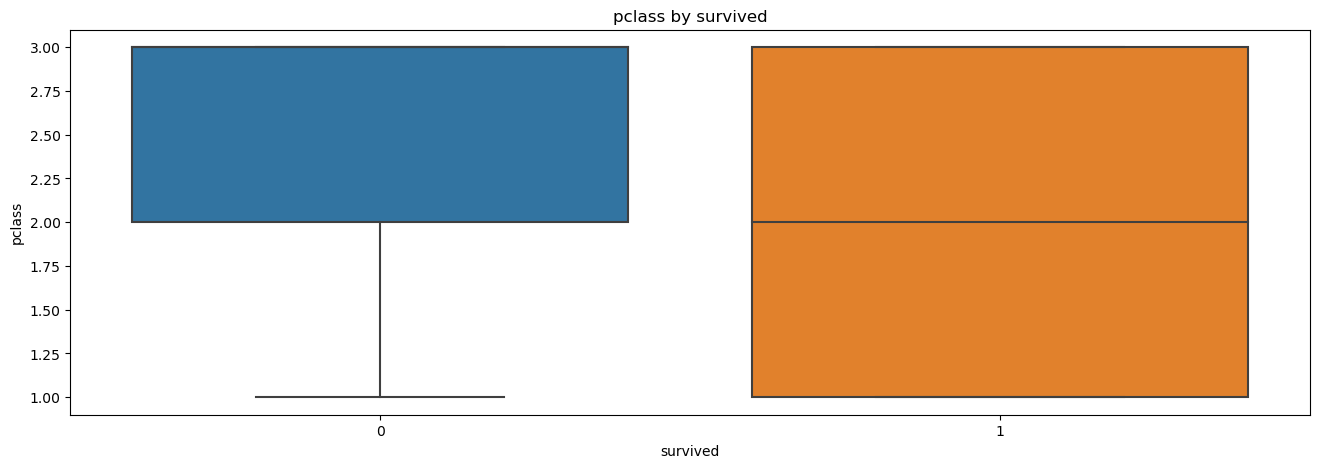

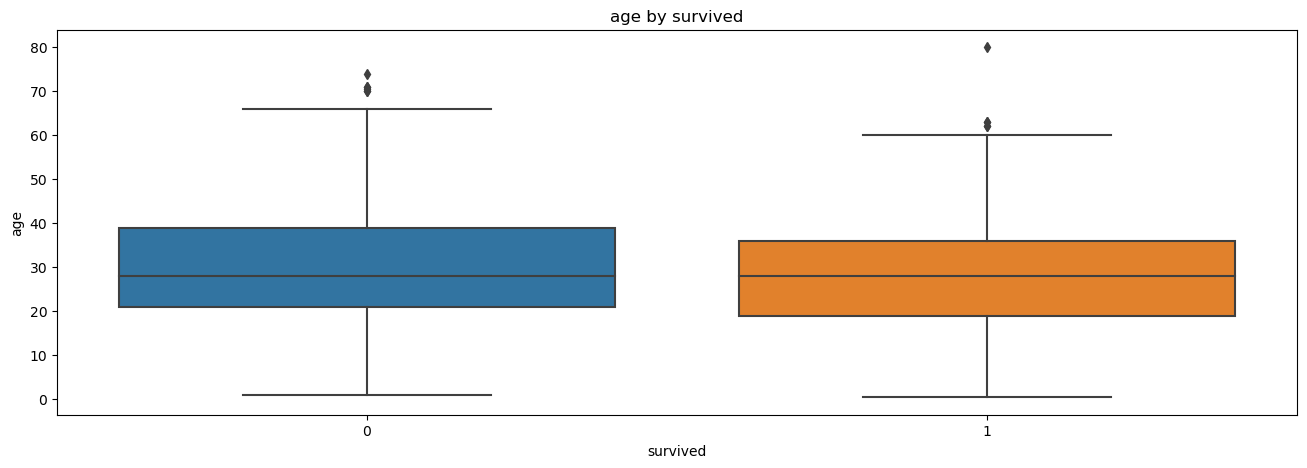

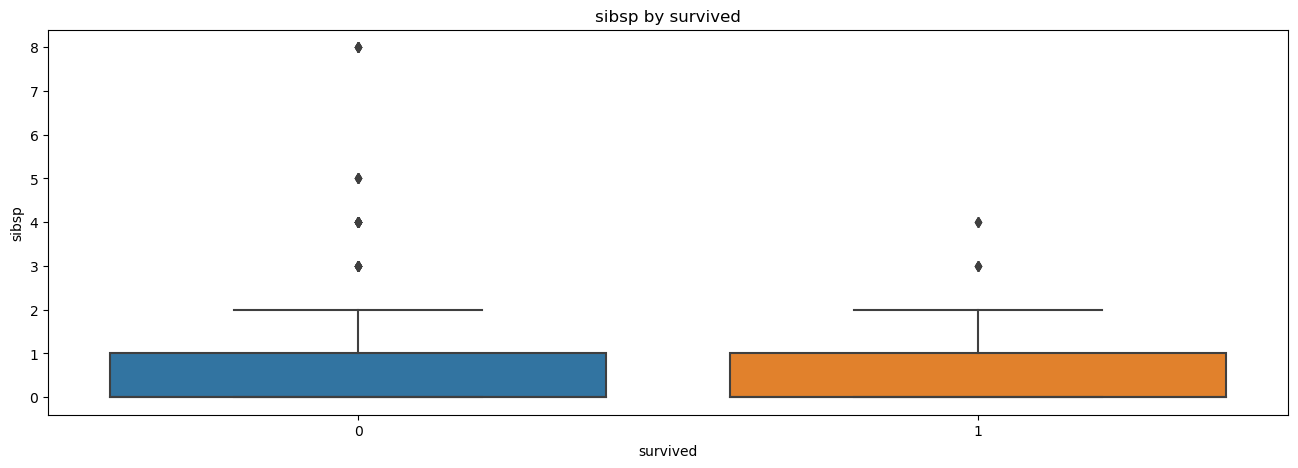

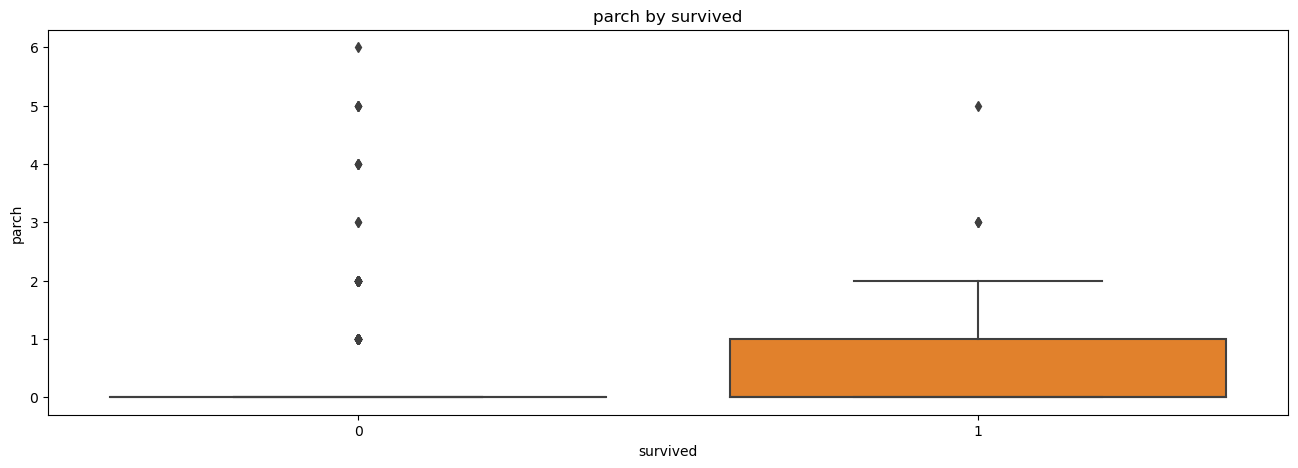

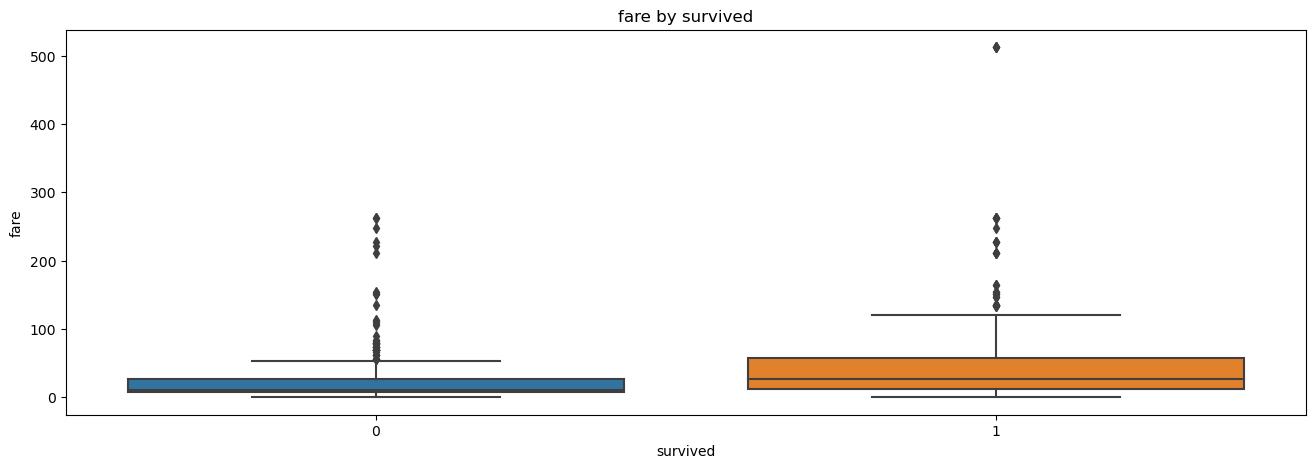

In [16]:
visualize_dataset(df, target_column="survived")


In [17]:
# Handling Missing Values Duplicate rows 
clean_dataset(df)

Initial shape: (891, 15)
Dropped columns with >50% missing: ['deck']


,survived,pclass,age,sibsp,parch,fare,adult_male,alone,sex_male,embarked_Q,embarked_S,class_Second,class_Third,who_man,who_woman,embark_town_Queenstown,embark_town_Southampton,alive_yes
0,-0.676908,0.719396,-0.823606,1.702946,0.0,-0.677003,True,False,True,False,True,False,True,True,False,False,True,False
2,1.477306,0.719396,-0.407105,-0.459015,0.0,-0.616739,False,True,False,False,True,False,True,False,True,False,True,True
3,1.477306,-1.927757,0.530022,1.702946,0.0,3.416502,False,False,False,False,True,False,False,False,True,False,True,True
4,-0.676908,0.719396,0.530022,-0.459015,0.0,-0.605579,True,True,True,False,True,False,True,True,False,False,True,False
5,-0.676908,0.719396,-0.198855,-0.459015,0.0,-0.569126,True,True,True,True,False,False,True,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
882,-0.676908,0.719396,-0.823606,-0.459015,0.0,-0.385351,False,True,False,False,True,False,True,False,True,False,True,False
883,-0.676908,-0.604181,-0.198855,-0.459015,0.0,-0.386842,True,True,True,False,True,True,False,True,False,False,True,False
887,1.477306,-1.927757,-1.135982,-0.459015,0.0,1.354125,False,True,False,False,True,False,False,False,True,False,True,True
889,1.477306,-1.927757,-0.407105,-0.459015,0.0,1.354125,True,True,True,False,False,False,False,True,False,False,False,True
